In [2]:
!pip install shap

In [3]:
import torch
import torchvision
import torch.nn as nn
from torchvision import transforms
import numpy as np
import shap
from torch.utils.data import DataLoader, Subset

In [4]:
np.random.seed(0)
torch.manual_seed(0)

In [5]:
# Define device and model parameters
device = 'cpu'  # Options: 'cpu', 'cuda' (for GPU)
batch_size = 200
epochs = 5

In [6]:
# Define the neural network model, using a simple MLP for MNIST
class MLP_MNIST(torch.nn.Module):
    def __init__(self):
        super(MLP_MNIST, self).__init__()
        self.fc1 = torch.nn.Linear(28*28, 512)
        self.fc2 = torch.nn.Linear(512, 10)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [7]:
from typing_extensions import Self

# added softmax
# converts them into soft probablity curve


class MLP_MNIST_Prob(torch.nn.Module):
    def __init__(self, base_model):
        super(MLP_MNIST_Prob, self).__init__()
        self.base_model = base_model  # your original MLP_MNIST

    def forward(self, x):
        logits = self.base_model(x)
        probs = F.softmax(logits, dim=1)  # convert to probabilities
        return probs

model def and other things def

In [8]:
import torch.nn.functional as F
model = MLP_MNIST().to(device)
model_probs = MLP_MNIST_Prob(model).to(device)  # Wrap original trained model

dont forget the the optims and the loss

In [9]:
optimizer = torch.optim.Adam(model.parameters())
loss_fn = torch.nn.CrossEntropyLoss()

download the MNIST data

In [10]:
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 42.4MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 1.46MB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 10.9MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 3.64MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



train and test oh shit

In [11]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

training loop

In [12]:
# Train the model (simplified training loop with logs for demonstration)
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()  # Summing loss for averaging later
    print(f"Epoch {epoch+1}, Average Loss: {total_loss / len(train_loader)}")

Epoch 1, Average Loss: 0.3609732197225094
Epoch 2, Average Loss: 0.15076458789408206
Epoch 3, Average Loss: 0.09985638581216336
Epoch 4, Average Loss: 0.07359100867062807
Epoch 5, Average Loss: 0.05559881423289577


In practice, SHAP picks or averages across one or more baseline samples (the background data) to estimate how the model behaves when a particular feature is “missing” (or replaced by a baseline/average value) vs. when it is present at its actual value in the data point you want to explain.

The background data usually comes from a subset of the training data (or another representative dataset) to reflect the model’s typical inputs.
For images, these samples often represent an average or “typical” distribution of pixel values. For tabular data, these samples represent typical feature values.

In [13]:
# Select a subset of data for Shapley value computation
background_data = Subset(train_dataset, indices=np.random.choice(len(train_dataset), 1000, replace=False))
background_loader = DataLoader(background_data, batch_size=1, shuffle=True)

sample cuz we cant handle the whole thing

In [14]:
# Create a background dataset for Deep SHAP
background_samples = torch.cat([data[0].unsqueeze(0) for data, _ in background_loader], 0).to(device)

In [15]:

# Initialize SHAP Deep Explainer
e = shap.DeepExplainer(model_probs, background_samples)


data_point, _ = next(iter(test_loader))  # Get a batch from the test loader
data_point = data_point.to(device)       # move data to the appropriate device
data_point = data_point[0:1]             # Select the first example from the batch

In [16]:
# Option to choose between DeepExplainer and GradientExplainer
try:
    e = shap.DeepExplainer(model_probs, background_samples)
    shap_values = e.shap_values(data_point)
except AssertionError as error:
    print("Switching to GradientExplainer due to error:", error)
    e = shap.GradientExplainer(model, background_samples)
    shap_values = e.shap_values(data_point)


# Adjust the shape of the data point for visualization
data_point = data_point.squeeze()  #

Switching to GradientExplainer due to error: The SHAP explanations do not sum up to the model's output! This is either because of a rounding error or because an operator in your computation graph was not fully supported. If the sum difference of %f is significant compared to the scale of your model outputs, please post as a github issue, with a reproducible example so we can debug it. Used framework: pytorch - Max. diff: 0.11429014255535921 - Tolerance: 0.01


In [17]:
# ensure data_point is reshaped correctly for grayscale visualization
if data_point.ndim == 3:
    data_point = data_point.permute(1, 2, 0)  # Convert from [C, H, W] to [H, W, C] if needed

# Check and adjust dimensions for shap_values if necessary
shap_values = [sv.squeeze() for sv in shap_values]  # Remove unnecessary batch dimension

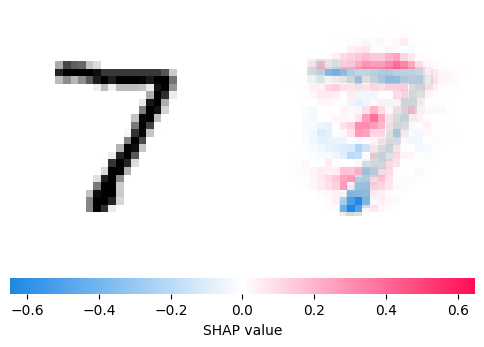

In [18]:
shap.image_plot(shap_values, -data_point.cpu().numpy())

A heatmap of SHAP values indicating how each pixel influences the model’s prediction.

**Positive (Red) Regions:** Pixels that push the model’s output toward the predicted class. Think of them as strong “evidence” in favor of the classification (here, a ‘7’).



**Negative (Blue) Regions:** Pixels that push the model’s output away from the predicted class. These areas, if changed, would make the model less likely to predict the digit as a ‘7’.

# In Run Data Shapley

## Reloading the previous model -

In [19]:
import torch.optim as optim
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(0)
np.random.seed(0)

class MLP_MNIST(nn.Module):
    def __init__(self):
        super(MLP_MNIST, self).__init__()
        self.fc1 = nn.Linear(28*28, 256)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Instantiate model, loss, optimizer
model = MLP_MNIST().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [20]:
transform = transforms.ToTensor()
train_dataset = torchvision.datasets.MNIST(root='./data', train=True,
                                           transform=transform, download=True)
val_dataset = torchvision.datasets.MNIST(root='./data', train=False,
                                         transform=transform, download=True)


In [22]:

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# Just pick a small subset of validation data for the demonstration
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=True)
val_data_iter = iter(val_loader)
# chosing the validation samples in the dataset
val_img, val_label = next(val_data_iter)
val_img, val_label = val_img.to(device), val_label.to(device)

data_shapley_scores[i] will hold the in-run shapley score for
the i-th sample in the entire train_dataset (index i in train_dataset)

In [27]:
data_shapley_scores = torch.zeros(len(train_dataset), device=device) # initiate an empty array


epochs = 1
global_step= 0

This dot product is a first-order approximation of how much the loss on the validation sample changes when a training sample is used to update the parameters.

We do one forward pass on the batch+val, and one backward pass. During this pass, we use hooks to capture:

    Each sample’s input xixi​ arriving at the layer (a forward hook).
    Each sample’s output gradient δiδi​ leaving the layer (a backward hook).

Hooks in pytorch are basically capturing information from point to point

we apply hook after we pass values thorugh logits
and we do while backprop

In [32]:
# ------------------------------------------
# 4. Training Loop with In-Run Data Shapley
# ------------------------------------------
model.train()
for epoch in range(epochs):
    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)



        # We create a combined batch:
        #   1) the normal training batch
        #   2) plus the single validation sample
        # to do "ghost dot-products" in ONE pass.
        # creates a 1D array to combine the images and validation set hence making it ghost dot product

        combined_imgs = torch.cat([images, val_img], dim=0)
        combined_labels = torch.cat([labels, val_label], dim=0)

    # Compute the loss on the combined set
        logits = model(combined_imgs) #
        train_batch_size = images.size(0)

    # The first part of logits is training data, the last part is for val data
        loss_train = loss_fn(logits[:train_batch_size], labels)
        loss_val   = loss_fn(logits[train_batch_size:], val_label)

        # Combined loss (we sum them so that backprop will let us
        # access both training-sample gradients and val-sample gradient)
        combined_loss = loss_train + loss_val



# Ghost dot product for backward pass
        optimizer.zero_grad()
        combined_loss.backward(retain_graph=True) # retain graph since we need more of the backprop later on

        saved_state = {} # save the current sate


# We store the current gradients (which are for train+val) in saved_state.
        for name, param in model.named_parameters():
            if param.grad is not None:
                # save param.grad clone for later use
                saved_state[name] = param.grad.detach().clone()



# zero the model gradient
# only use val for back/forward pass
        optimizer.zero_grad()
        logits_val_only = model(val_img)
        loss_val_only = loss_fn(logits_val_only, val_label)
        loss_val_only.backward(create_graph=False)  # single-sample gradient
        grad_val = {}
        for name, param in model.named_parameters():
            if param.grad is not None:
                grad_val[name] = param.grad.detach().clone()



        # restore the combined grad from saved_state
        for name, param in model.named_parameters():
            if name in saved_state:
                param.grad = saved_state[name] # now when it is in param save it to saved_state


        # Now let's compute the "dot product" for each sample in the train batch:
        for i in range(train_batch_size):
            # zero grad
            param_zero = {}
            for name, param in model.named_parameters():
                if param.grad is not None:
                    param.grad.zero_()

            # backward on just the i-th example in the train batch
            single_logit = model(images[i].unsqueeze(0))
            single_loss = loss_fn(single_logit, labels[i].unsqueeze(0))
            single_loss.backward()

            # read off dot-product with grad_val
            dot_val = 0.0
            for name, param in model.named_parameters():
                if param.grad is not None and name in grad_val:
                    # flatten both param.grad and grad_val[name]
                    dot_val += (param.grad.view(-1) * grad_val[name].view(-1)).sum()

            # Add to data_shapley_scores
            idx_in_full_dataset = batch_idx*batch_size + i  # approximate global index
            data_shapley_scores[idx_in_full_dataset] += -0.01 * dot_val.item() # mul by lr to scale back things


            # We used lr=0.01 -> so multiply by -lr. Negative sign because the loss change is -( grad_val · grad_train_i ).

# Final logging

        optimizer.step()

        global_step += 1
        if batch_idx % 100 == 0:
            print(f"Epoch {epoch}, Step {batch_idx}, combined_loss = {combined_loss.item():.4f}")


Epoch 0, Step 0, combined_loss = 3.2223
Epoch 0, Step 100, combined_loss = 5.5803
Epoch 0, Step 200, combined_loss = 1.4972
Epoch 0, Step 300, combined_loss = 2.8802
Epoch 0, Step 400, combined_loss = 0.9619
Epoch 0, Step 500, combined_loss = 2.4942
Epoch 0, Step 600, combined_loss = 2.7236
Epoch 0, Step 700, combined_loss = 5.3820
Epoch 0, Step 800, combined_loss = 2.8438
Epoch 0, Step 900, combined_loss = 2.2997


Why Is This “Ghost”?

    We never explicitly built a huge per-sample gradient tensor. Instead, we stored only a few intermediate tensors (xi(l)xi(l)​ and δi(l)δi(l)​ for each sample).

    this helps us store info on the fly

In [34]:
print("In-Run Data Shapley (first-order approx) computed for each training sample.")
print("data_shapley_scores shape:", data_shapley_scores.shape)

In-Run Data Shapley (first-order approx) computed for each training sample.
data_shapley_scores shape: torch.Size([60000])


- For each training example, you are estimating a “first-order approximation” of how much that example contributes (positively or negatively) to reducing the validation sample’s loss.

- By the end, you’ll have data_shapley_scores[i] telling you whether sample i is beneficial (a positive contribution reduces validation loss) or detrimental (a negative contribution might increase validation loss).


# What more to do

1. plot the contribution graph over time to segregate positive and negative contribution on this
2. maybe remove the negative ones and see how that affects performance



# ALSO -

- Dynamic Re-weighting: Use the Shapley scores as dynamic “weights” for each training sample in the objective, so that negative contributors are downweighted in real time.

- Curriculum Learning: Potentially design a curriculum where you first train on high-contribution samples, then gradually introduce lower-contribution samples.

- Subset Selection: If you have a very large dataset, you might only train on the subset of samples with the highest Shapley contribution, speeding up training but still achieving good performance on your validation set.

In [36]:
# Maybe some sorting


import torch

sorted_shite = torch.argsort(data_shapley_scores)

print("HIghest shapley scores")
for rank in range(10):
    idx = sorted_shite[rank].item()        # index in the dataset
    val = data_shapley_scores[idx].item()    # Shapley score
    print(f"Rank {rank+1:2d} | Sample Index: {idx:5d} | Score: {val:.4f}")



print("Lowest shapley scores")
for rank in range(10):
    idx = sorted_shite[-(rank+1)].item()   # index from the end
    val = data_shapley_scores[idx].item()    # Shapley score
    print(f"Rank {rank+1:2d} | Sample Index: {idx:5d} | Score: {val:.4f}")


HIghest shapley scores
Rank  1 | Sample Index: 46542 | Score: -3.9043
Rank  2 | Sample Index: 48812 | Score: -3.8358
Rank  3 | Sample Index: 39066 | Score: -3.7442
Rank  4 | Sample Index:  7147 | Score: -3.6062
Rank  5 | Sample Index: 49441 | Score: -3.5339
Rank  6 | Sample Index: 44791 | Score: -3.5203
Rank  7 | Sample Index: 45104 | Score: -3.4897
Rank  8 | Sample Index: 35108 | Score: -3.4149
Rank  9 | Sample Index: 43943 | Score: -3.4097
Rank 10 | Sample Index: 51668 | Score: -3.4073
Lowest shapley scores
Rank  1 | Sample Index: 34313 | Score: 2.5663
Rank  2 | Sample Index: 59127 | Score: 2.4685
Rank  3 | Sample Index: 55037 | Score: 2.4204
Rank  4 | Sample Index: 27612 | Score: 2.3866
Rank  5 | Sample Index: 27596 | Score: 2.3051
Rank  6 | Sample Index: 51275 | Score: 2.2888
Rank  7 | Sample Index: 52996 | Score: 2.2684
Rank  8 | Sample Index: 29027 | Score: 2.2673
Rank  9 | Sample Index: 45182 | Score: 2.1143
Rank 10 | Sample Index: 50776 | Score: 2.0524
